# Library

In [2]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# Data Load

In [3]:
m1 = pd.read_csv('method1_df.csv')
m2 = pd.read_csv('method2_df.csv')

# Method 1 : 상위 10개 feature
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [4]:
m1['abs'] = abs(m1['mul'])
m1 = m1.sort_values(by='abs', ascending=False)
m1_top10 = m1['feature'].values[:10]
m1_top10

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
            227194,    54858516,    74706811,    45006701,     4003822])

## (65.1) RF

In [54]:
# m1_top10만을 가진 x_(7727,10)_m1 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m1_top10_index]
x_2d.shape

# np.save('x_(7727,10)_m1.npy',x_2d)

m1_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10)

In [53]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m1.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6355987055016181, seed_num = 42
정확도 : 0.6330097087378641, seed_num = 43
정확도 : 0.6349514563106796, seed_num = 44
정확도 : 0.6576051779935275, seed_num = 45
정확도 : 0.6466019417475728, seed_num = 46
정확도 : 0.6634304207119741, seed_num = 47
정확도 : 0.6750809061488673, seed_num = 48
정확도 : 0.654368932038835, seed_num = 49
정확도 : 0.6640776699029126, seed_num = 50
정확도 : 0.6511326860841424, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65158576]


## (64.9) LSTM

In [58]:
# m1_top10만을 가진 x_(7727,10,10)_m1 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m1_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_m1.npy',x_3d)

m1_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10, 10)

6187.0

In [60]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm1_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 6s 55ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/10개 feature/seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 43ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66551, saving model to ./model/10개 feature/seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66551 to 0.66526, saving model to ./model/10개 feature/seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 2s 43ms/step - loss: 0.670

37/37 [==============================] - 2s 44ms/step - loss: 0.6109 - acc: 0.6381 - val_loss: 0.6170 - val_acc: 0.6475

Epoch 00039: val_loss improved from 0.61935 to 0.61702, saving model to ./model/10개 feature/seed42-39-0.6170.hdf5
Epoch 40/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6101 - acc: 0.6372 - val_loss: 0.6157 - val_acc: 0.6481

Epoch 00040: val_loss improved from 0.61702 to 0.61572, saving model to ./model/10개 feature/seed42-40-0.6157.hdf5
Epoch 41/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6077 - acc: 0.6413 - val_loss: 0.6145 - val_acc: 0.6514

Epoch 00041: val_loss improved from 0.61572 to 0.61446, saving model to ./model/10개 feature/seed42-41-0.6145.hdf5
Epoch 42/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6034 - acc: 0.6462 - val_loss: 0.6134 - val_acc: 0.6514

Epoch 00042: val_loss improved from 0.61446 to 0.61336, saving model to ./model/10개 feature/seed42-42-0.6134.hdf5
Epoch 43/500
37/37 [=

37/37 [==============================] - 2s 44ms/step - loss: 0.5987 - acc: 0.6540 - val_loss: 0.6138 - val_acc: 0.6533

Epoch 00081: val_loss did not improve from 0.61251
Epoch 82/500
37/37 [==============================] - 2s 44ms/step - loss: 0.5985 - acc: 0.6540 - val_loss: 0.6154 - val_acc: 0.6533

Epoch 00082: val_loss did not improve from 0.61251
Epoch 83/500
37/37 [==============================] - 2s 44ms/step - loss: 0.5980 - acc: 0.6536 - val_loss: 0.6161 - val_acc: 0.6533

Epoch 00083: val_loss did not improve from 0.61251
Epoch 84/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6000 - acc: 0.6547 - val_loss: 0.6123 - val_acc: 0.6533

Epoch 00084: val_loss improved from 0.61251 to 0.61229, saving model to ./model/10개 feature/seed42-84-0.6123.hdf5
Epoch 85/500
37/37 [==============================] - 2s 44ms/step - loss: 0.5988 - acc: 0.6536 - val_loss: 0.6151 - val_acc: 0.6533

Epoch 00085: val_loss did not improve from 0.61229
Epoch 86/500
37/37 [=====

In [63]:
from keras.models import load_model
best_model = load_model('./model/m1_top10_seed42-84-0.6123.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6466019417475728, seed_num = 0
정확도 :0.6427184466019418, seed_num = 1
정확도 :0.6498381877022654, seed_num = 2
정확도 :0.6375404530744336, seed_num = 3
정확도 :0.654368932038835, seed_num = 4
정확도 :0.655663430420712, seed_num = 5
정확도 :0.6537216828478964, seed_num = 6
정확도 :0.629126213592233, seed_num = 7
정확도 :0.6614886731391586, seed_num = 8
정확도 :0.6498381877022654, seed_num = 9
정확도 :0.627831715210356, seed_num = 10
정확도 :0.6711974110032363, seed_num = 11
정확도 :0.6472491909385113, seed_num = 12
정확도 :0.6414239482200648, seed_num = 13
정확도 :0.6466019417475728, seed_num = 14
정확도 :0.656957928802589, seed_num = 15
정확도 :0.6692556634304208, seed_num = 16
정확도 :0.6453074433656958, seed_num = 17
정확도 :0.6459546925566343, seed_num = 18
정확도 :0.6414239482200648, seed_num = 19
정확도 :0.6601941747572816, seed_num = 20
정확도 :0.6595469255663431, seed_num = 21
정확도 :0.6375404530744336, seed_num = 22
정확도 :0.6550161812297735, seed_num = 23
정확도 :0.6530744336569579, seed_num = 24
정확도 :0.6491909385113268, seed_num = 25
정

In [64]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.649204
dtype: float64

## (64.9) not saved LSTM

In [82]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=False)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
37/37 [==============================] - 4s 46ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177
Epoch 2/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177
Epoch 3/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177
Epoch 4/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177
Epoch 5/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6706 - acc: 0.6091 - val_loss: 0.6652 - val_acc: 0.6177
Epoch 6/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6721 - acc: 0.6113 - val_loss: 0.6652 - val_acc: 0.6177
Epoch 7/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6710 - acc: 0.6111 - val_loss: 0.6652 - val_acc: 0.6177
Epoch 8/500
37/37 [==============================] - 1s 37ms/step - loss: 0.

In [83]:
dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = lstm.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6459546925566343, seed_num = 0
정확도 :0.6427184466019418, seed_num = 1
정확도 :0.6498381877022654, seed_num = 2
정확도 :0.6375404530744336, seed_num = 3
정확도 :0.654368932038835, seed_num = 4
정확도 :0.655663430420712, seed_num = 5
정확도 :0.6537216828478964, seed_num = 6
정확도 :0.629126213592233, seed_num = 7
정확도 :0.6614886731391586, seed_num = 8
정확도 :0.6491909385113268, seed_num = 9
정확도 :0.627831715210356, seed_num = 10
정확도 :0.6711974110032363, seed_num = 11
정확도 :0.6472491909385113, seed_num = 12
정확도 :0.6414239482200648, seed_num = 13
정확도 :0.6466019417475728, seed_num = 14
정확도 :0.6563106796116505, seed_num = 15
정확도 :0.6692556634304208, seed_num = 16
정확도 :0.6446601941747573, seed_num = 17
정확도 :0.6453074433656958, seed_num = 18
정확도 :0.6414239482200648, seed_num = 19
정확도 :0.6601941747572816, seed_num = 20
정확도 :0.6588996763754046, seed_num = 21
정확도 :0.6375404530744336, seed_num = 22
정확도 :0.6550161812297735, seed_num = 23
정확도 :0.6530744336569579, seed_num = 24
정확도 :0.6491909385113268, seed_num = 25


In [84]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.64901
dtype: float64

# RF : 상위 10개 feature 
- x_(7727,10)_rf.npy 저장

In [47]:
# x_(7727,4068).npy 저장
x1 = np.load('x_(7727,10,4068).npy')
x1 = x1.sum(axis=1)
x1.sum(), x1.shape

x1_ = x1.copy()
x1_[x1_>1] = 1
x1_.sum()

# np.save('x_(7727,4068).npy', x1_)

(2042722.0, (7727, 4068))

510420.0

In [48]:
# RF 기준으로 상위 10개 feature 선별
total_data = pd.read_csv('total_data_7727.csv')
features = list(total_data['ITEMID'].sort_values().unique())

import random
random.seed(42)
x = np.load('x_(7727,4068).npy')
y = np.load('y_(7727,1).npy')

In [49]:
# RF에 내장된 feature importance 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

model = RandomForestClassifier()
model.fit(x, y)

importances = model.feature_importances_

result = []
for f in range(x.shape[1]):
    result.append({'feature' : features[f], 'importance' : importances[f]})

RandomForestClassifier()

In [50]:
# rf_top10 itemid 골라내기 
df = pd.DataFrame(result)
df = df.sort_values(by='importance',ascending=False)
rf_top10 = df['feature'].values[:10]
rf_top10

array([      51277,       51006,       50912,       50862,       50983,
       63323026201,       50882,   904224461,   409606211,       51003])

In [51]:
# rf_top10만을 가진 x_(7727,10)_rf 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

rf_top10_index = []
for i in rf_top10:
    rf_top10_index.append(item_list.index(i))

print('rf_top10의 index : ',rf_top10_index)

x_2d = x[:,rf_top10_index]
x_2d.shape

# np.save('x_(7727,10)_rf.npy',x_2d)

rf_top10의 index :  [206, 121, 56, 20, 103, 3832, 34, 2611, 2195, 119]


(7727, 10)

## absum 그래프

In [5]:
total_data = pd.read_csv('total_data_7727.csv')
x = np.load('/project/LSH/x_(7727,10,4068).npy')

def absum(PPL_list,top_or_down):
    # 1) PRE_top10의 index 구하기
    PPL_top10 = top_or_down
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in PPL_top10:
        a = list(item_list).index(i)
        PPL_index.append(a)
    
    # 2) 생존자 index 구하기 
    sub7727 = total_data['SUBJECT_ID'].unique()

    patient = pd.read_csv('폐렴환자.csv')
    patient = patient.sort_values(by='SUBJECT_ID')
    patient = patient[patient['SUBJECT_ID'].isin(sub7727)]
    sub_1_list = patient[patient['EXPIRE_FLAG']==0]['SUBJECT_ID'].values

    생존자_index = []
    for i in sub_1_list:
        생존자_index.append(list(sub7727).index(i))
        
    # 3) 생존자 3009명의 D-10 ~ D-1 feature별 abnormal sum 
    x_생존자 = x[생존자_index,:,:]

    result1 = []
    for i in PPL_index:
        for j in range(10):
            result1.append(x_생존자[:,j,i].sum())

    result1 = np.array(result1)
    result1 = result1.reshape(10,-1)
    df_PPL = pd.DataFrame(result1)
    df_PPL.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL.index = PPL_top10

    # 생존한 4718명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL.loc[f'{i}_생존'] = df_PPL.loc[i].iloc[:]/x_생존자.shape[0]
        
    # 4) 사망자 4718명의 D-10 ~ D-1 feature별 abnormal sum 
    사망자_index = list(set(range(0,7727))-set(생존자_index))

    x_사망자 = x[사망자_index,:,:]

    result2 = []
    for i in PPL_index:
        for j in range(10):
            result2.append(x_사망자[:,j,i].sum())

    result2 = np.array(result2)
    result2 = result2.reshape(10,-1)
    df_PPL_사망자 = pd.DataFrame(result2)
    df_PPL_사망자.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL_사망자.index = PPL_top10

    # 사망한 3009명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL_사망자.loc[f'{i}_사망'] = df_PPL_사망자.loc[i]/x_사망자.shape[0] 
        
    # 5) for문으로 각 feature에 대한 비율 추이 그래프 그리기 

    df_PPL_trans = df_PPL.transpose()
    df_PPL_사망자_trans = df_PPL_사망자.transpose()

    _ = plt.figure(figsize = (13,12),dpi=150)
    for i, f in enumerate(PPL_top10): 
        _ = plt.subplot(4,3,1+i)
        _ = plt.title(f)
        _ = ax = sns.lineplot(data = df_PPL_사망자_trans, x = df_PPL_사망자_trans.index, y = f'{f}_사망')
        _ = ax = sns.lineplot(data = df_PPL_trans, x = df_PPL_trans.index, y = f'{f}_생존')
        _ = ax.legend(labels = ['사망', '생존'], loc = 'upper left', fontsize=12)
        _ = ax.set_ylabel('per', fontsize = 12)

    plt.tight_layout()

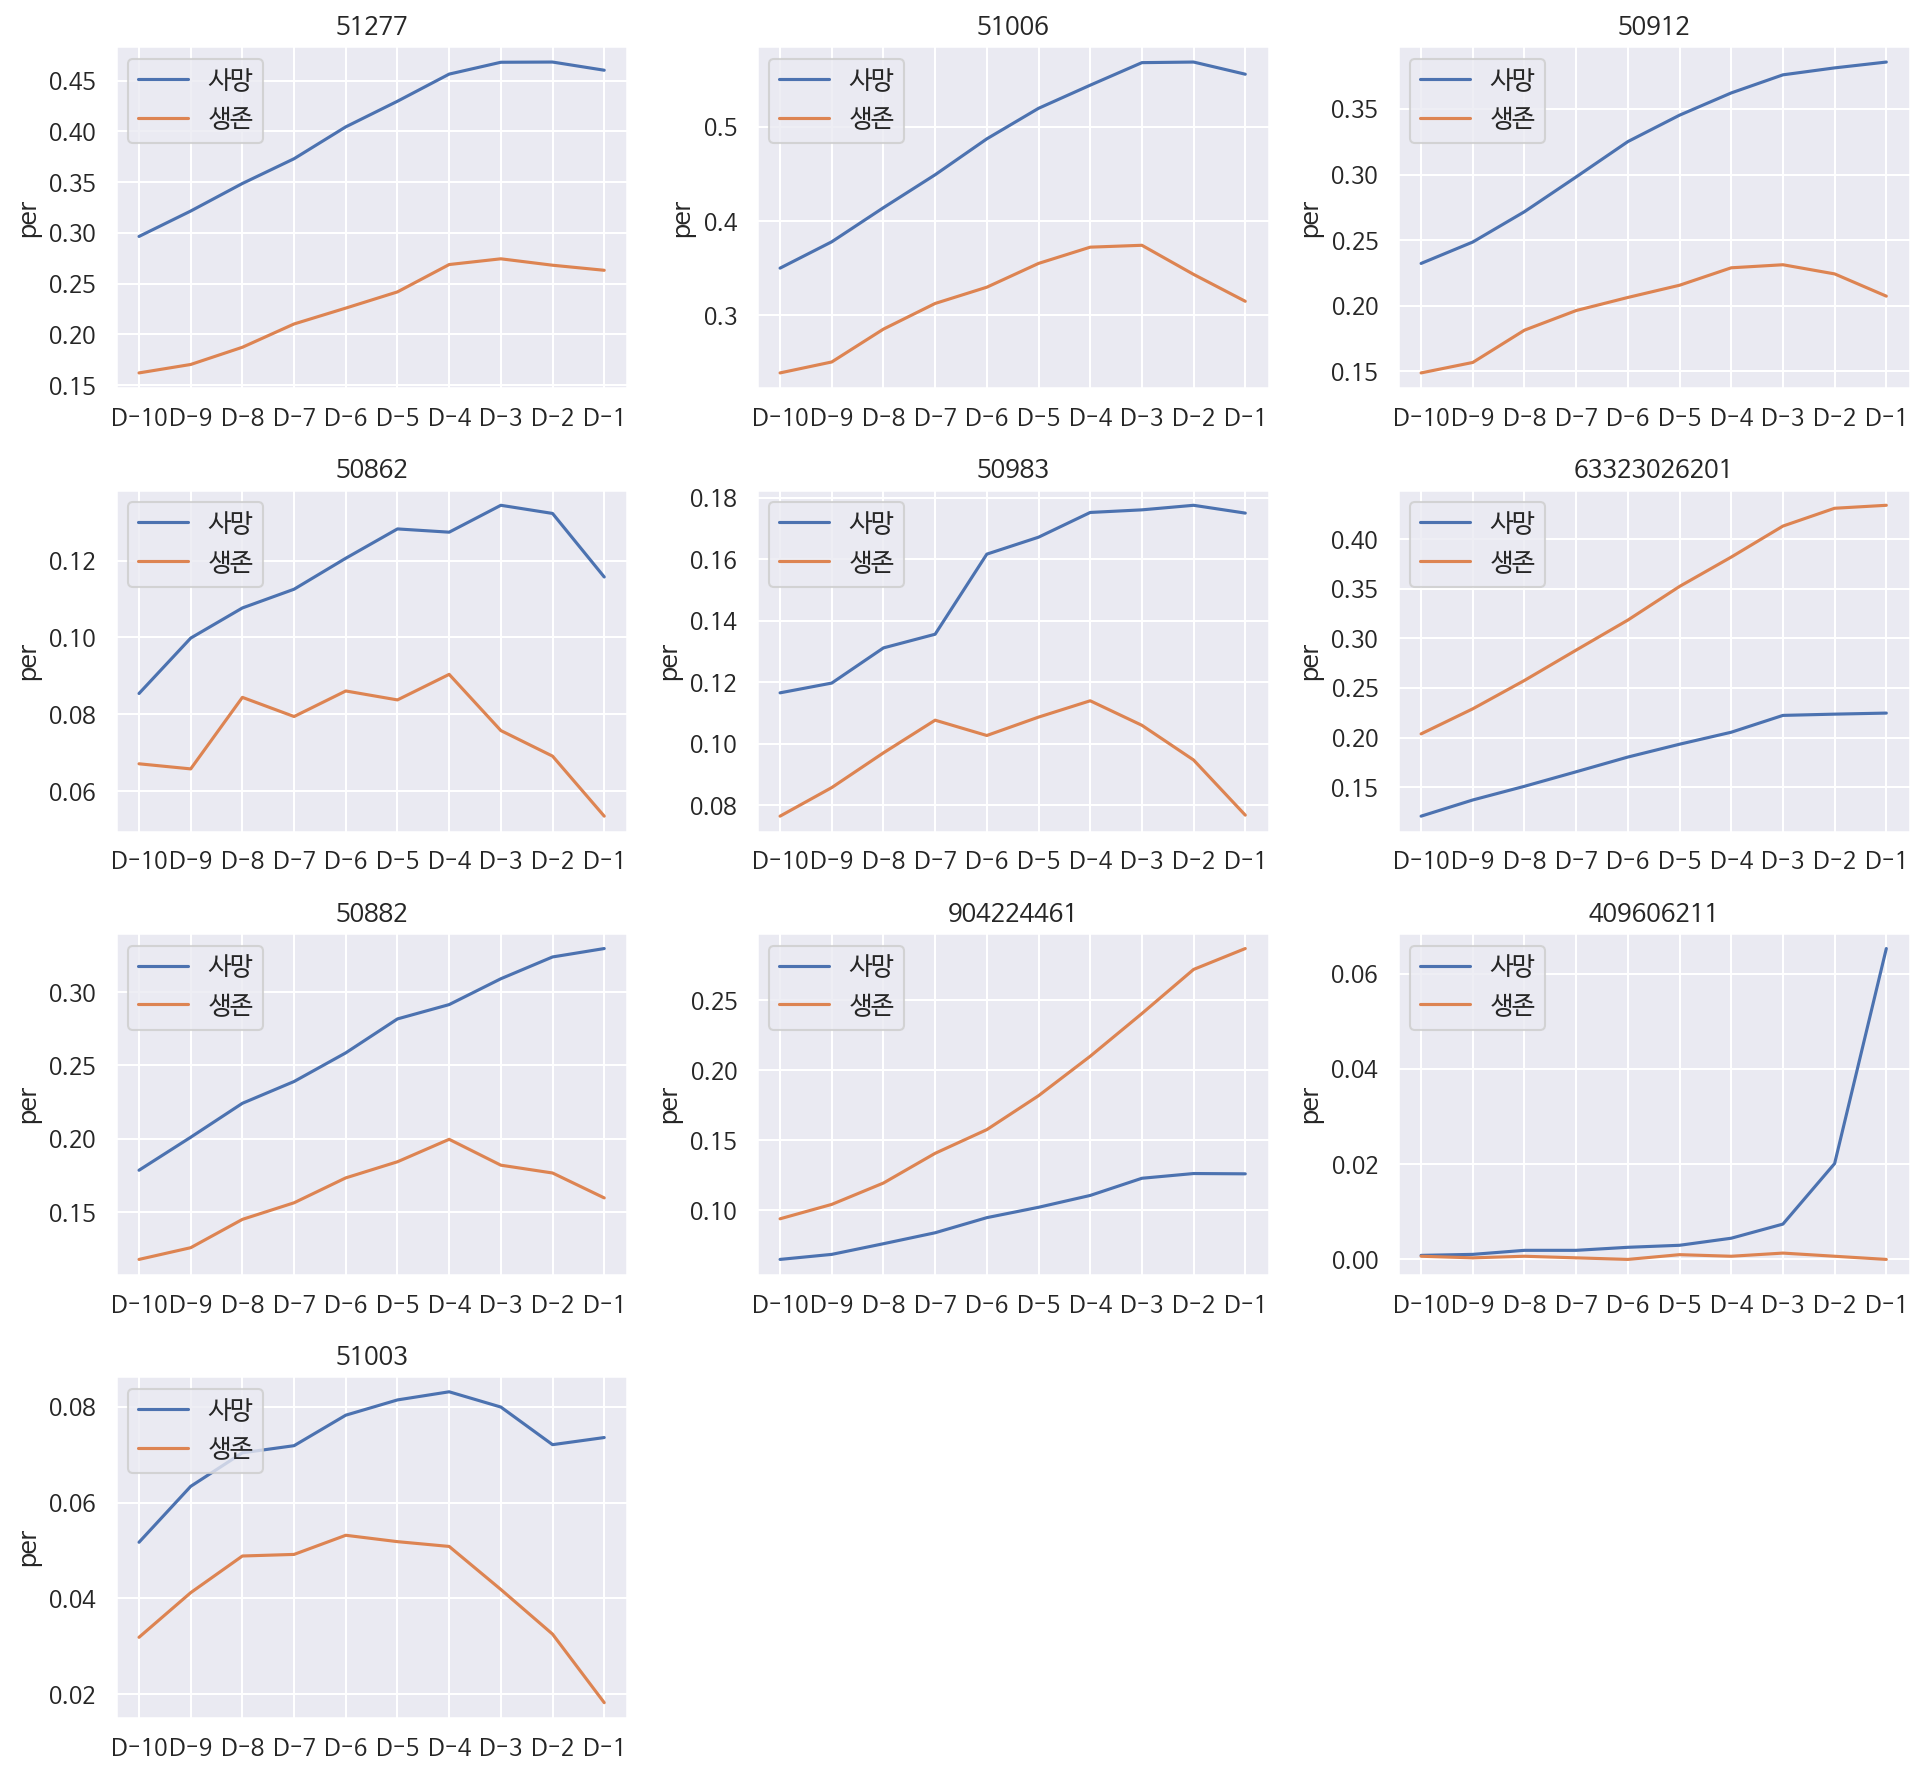

In [3]:
RF_list = [51277, 51006, 50912, 50862, 50983, 
           63323026201, 50882, 904224461, 409606211, 51003]
absum(RF_list,RF_list[:10])

## (67.3) RF

In [45]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_rf.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6763754045307443, seed_num = 42
정확도 : 0.6692556634304208, seed_num = 43
정확도 : 0.6550161812297735, seed_num = 44
정확도 : 0.6653721682847896, seed_num = 45
정확도 : 0.6899676375404531, seed_num = 46
정확도 : 0.6673139158576051, seed_num = 47
정확도 : 0.6957928802588996, seed_num = 48
정확도 : 0.6802588996763754, seed_num = 49
정확도 : 0.658252427184466, seed_num = 50
정확도 : 0.6724919093851133, seed_num = 51
정확도 df 만들고 평균 확인 : [0.67300971]


## (72.0) LSTM

In [65]:
# rf_top10만을 가진 x_(7727,10,10)_rf 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

rf_top10_index = []
for i in rf_top10:
    rf_top10_index.append(item_list.index(i))

print('rf_top10의 index : ',rf_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,rf_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_rf.npy',x_3d)

rf_top10의 index :  [206, 121, 56, 20, 103, 3832, 34, 2611, 2195, 119]


(7727, 10, 10)

148506.0

In [67]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_rf.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'rf_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 5s 54ms/step - loss: 0.6758 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66596, saving model to ./model/rf_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6730 - acc: 0.6068 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66596
Epoch 3/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6730 - acc: 0.6085 - val_loss: 0.6632 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66596 to 0.66323, saving model to ./model/rf_top10_seed42-03-0.6632.hdf5
Epoch 4/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6547 - acc: 0.6158 - val_loss: 0.6207 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66323 to 0.62068, saving model to ./model/rf_top10_seed42-04-0.6207.hdf5
Epoch 5/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6056 - acc: 

Epoch 39/500
37/37 [==============================] - 1s 38ms/step - loss: 0.5503 - acc: 0.7204 - val_loss: 0.5570 - val_acc: 0.7038

Epoch 00039: val_loss improved from 0.55857 to 0.55695, saving model to ./model/rf_top10_seed42-39-0.5570.hdf5
Epoch 40/500
37/37 [==============================] - 1s 38ms/step - loss: 0.5485 - acc: 0.7220 - val_loss: 0.5567 - val_acc: 0.7031

Epoch 00040: val_loss improved from 0.55695 to 0.55672, saving model to ./model/rf_top10_seed42-40-0.5567.hdf5
Epoch 41/500
37/37 [==============================] - 1s 37ms/step - loss: 0.5504 - acc: 0.7183 - val_loss: 0.5572 - val_acc: 0.7018

Epoch 00041: val_loss did not improve from 0.55672
Epoch 42/500
37/37 [==============================] - 1s 37ms/step - loss: 0.5464 - acc: 0.7174 - val_loss: 0.5568 - val_acc: 0.6999

Epoch 00042: val_loss did not improve from 0.55672
Epoch 43/500
37/37 [==============================] - 1s 37ms/step - loss: 0.5488 - acc: 0.7213 - val_loss: 0.5577 - val_acc: 0.7031

Epoch 

In [68]:
from keras.models import load_model
best_model = load_model('./model/rf_top10_seed42-64-0.5546.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_rf.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.7165048543689321, seed_num = 0
정확도 :0.7249190938511327, seed_num = 1
정확도 :0.7171521035598706, seed_num = 2
정확도 :0.7242718446601941, seed_num = 3
정확도 :0.7242718446601941, seed_num = 4
정확도 :0.7165048543689321, seed_num = 5
정확도 :0.7190938511326861, seed_num = 6
정확도 :0.7216828478964401, seed_num = 7
정확도 :0.7313915857605178, seed_num = 8
정확도 :0.7216828478964401, seed_num = 9
정확도 :0.7249190938511327, seed_num = 10
정확도 :0.7385113268608414, seed_num = 11
정확도 :0.7365695792880259, seed_num = 12
정확도 :0.7190938511326861, seed_num = 13
정확도 :0.7288025889967638, seed_num = 14
정확도 :0.7190938511326861, seed_num = 15
정확도 :0.7190938511326861, seed_num = 16
정확도 :0.7158576051779936, seed_num = 17
정확도 :0.7268608414239482, seed_num = 18
정확도 :0.7216828478964401, seed_num = 19
정확도 :0.7126213592233009, seed_num = 20
정확도 :0.6996763754045308, seed_num = 21
정확도 :0.7223300970873786, seed_num = 22
정확도 :0.713915857605178, seed_num = 23
정확도 :0.7003236245954693, seed_num = 24
정확도 :0.7307443365695793, seed_num = 

In [69]:
# seed = 42의 정확도 df 만들고 평균 확인 => 72.0
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.720673
dtype: float64

# Method 2 : 상위 10개 feature
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [71]:
m2['abs'] = abs(m2['diff2'])
m2 = m2.sort_values(by='abs', ascending=False)
m2_top10 = m2['feature'].values[:10]
m2_top10

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
          54858516,    74706811,    45006701,      228125, 63323016501])

## (60.9) RF

In [72]:
# m2_top10만을 가진 x_(7727,10)_m2 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m2_top10_index = []
for i in m2_top10:
    m2_top10_index.append(item_list.index(i))

print('m2_top10의 index : ',m2_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m2_top10_index]
x_2d.shape

# np.save('x_(7727,10)_m2.npy',x_2d)

m2_top10의 index :  [2195, 1276, 1081, 982, 2744, 1011, 1306, 845, 392, 3820]


(7727, 10)

In [73]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m2.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6006472491909385, seed_num = 42
정확도 : 0.5844660194174758, seed_num = 43
정확도 : 0.594822006472492, seed_num = 44
정확도 : 0.6148867313915858, seed_num = 45
정확도 : 0.6116504854368932, seed_num = 46
정확도 : 0.626537216828479, seed_num = 47
정확도 : 0.627831715210356, seed_num = 48
정확도 : 0.5980582524271845, seed_num = 49
정확도 : 0.625242718446602, seed_num = 50
정확도 : 0.6122977346278318, seed_num = 51
정확도 df 만들고 평균 확인 : [0.60964401]


## (60.8) LSTM

In [74]:
# m2_top10만을 가진 x_(7727,10,10)_m2 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m2_top10_index = []
for i in m2_top10:
    m2_top10_index.append(item_list.index(i))

print('m2_top10의 index : ',m2_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m2_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_m2.npy',x_3d)

m2_top10의 index :  [2195, 1276, 1081, 982, 2744, 1011, 1306, 845, 392, 3820]


(7727, 10, 10)

5833.0

In [75]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m2.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm2_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 4s 47ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/m2_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66551, saving model to ./model/m2_top10_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66551 to 0.66526, saving model to ./model/m2_top10_seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6706 - acc: 

In [76]:
from keras.models import load_model
best_model = load_model('./model/m2_top10_seed42-46-0.6226.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m2.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6045307443365696, seed_num = 0
정확도 :0.6051779935275081, seed_num = 1
정확도 :0.6110032362459547, seed_num = 2
정확도 :0.602588996763754, seed_num = 3
정확도 :0.6097087378640776, seed_num = 4
정확도 :0.6110032362459547, seed_num = 5
정확도 :0.6110032362459547, seed_num = 6
정확도 :0.5928802588996763, seed_num = 7
정확도 :0.6226537216828479, seed_num = 8
정확도 :0.6129449838187703, seed_num = 9
정확도 :0.5909385113268608, seed_num = 10
정확도 :0.6297734627831715, seed_num = 11
정확도 :0.601294498381877, seed_num = 12
정확도 :0.598705501618123, seed_num = 13
정확도 :0.6071197411003236, seed_num = 14
정확도 :0.6135922330097088, seed_num = 15
정확도 :0.6330097087378641, seed_num = 16
정확도 :0.598705501618123, seed_num = 17
정확도 :0.6045307443365696, seed_num = 18
정확도 :0.596116504854369, seed_num = 19
정확도 :0.6187702265372168, seed_num = 20
정확도 :0.6135922330097088, seed_num = 21
정확도 :0.6, seed_num = 22
정확도 :0.6032362459546926, seed_num = 23
정확도 :0.6032362459546926, seed_num = 24
정확도 :0.6071197411003236, seed_num = 25
정확도 :0.595469255

In [77]:
# seed = 42의 정확도 df 만들고 평균 확인 => 60.8
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.608298
dtype: float64

# Method 1 - LSTM all fit
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [3]:
m1_all = pd.read_csv('method1_df_allfit.csv')
m1_all['abs'] = abs(m1_all['mul'])
m1_all = m1_all.sort_values(by='abs', ascending=False)
m1_top10 = m1_all['feature'].values[:10]
m1_top10

array([  409606211,      227194,     4003822,       50889,   182138167,
          74606211,       51200, 25021011210, 63323016101, 63323038810])

## (65.7) RF

In [7]:
# m1_top10만을 가진 x_(7727,10)_m1_allfit 만들기
total_data = pd.read_csv('total_data_7727.csv')
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m1_top10_index]
x_2d.shape

# np.save('x_(7727,10)_m1_allfit.npy',x_2d)

m1_top10의 index :  [2195, 383, 469, 37, 1815, 1276, 162, 2860, 3818, 3852]


(7727, 10)

In [8]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m1_allfit.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6407766990291263, seed_num = 42
정확도 : 0.6498381877022654, seed_num = 43
정확도 : 0.6472491909385113, seed_num = 44
정확도 : 0.6627831715210356, seed_num = 45
정확도 : 0.6524271844660194, seed_num = 46
정확도 : 0.6634304207119741, seed_num = 47
정확도 : 0.6750809061488673, seed_num = 48
정확도 : 0.6576051779935275, seed_num = 49
정확도 : 0.6731391585760518, seed_num = 50
정확도 : 0.6537216828478964, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65760518]


## (65.4) LSTM

In [9]:
# m1_top10만을 가진 x_(7727,10,10)_m1_allfit 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m1_top10_index]
x_3d.shape
x_3d.sum()

np.save('x_(7727,10,10)_m1_allfit.npy',x_3d)

m1_top10의 index :  [2195, 383, 469, 37, 1815, 1276, 162, 2860, 3818, 3852]


(7727, 10, 10)

4419.0

In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1_allfit.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm1_top10_allfit_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 6s 73ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/m1_top10_allfit_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6732 - acc: 0.6068 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66552, saving model to ./model/m1_top10_allfit_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 66ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66552 to 0.66527, saving model to ./model/m1_top10_allfit_seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 2s 64ms/step -


Epoch 00037: val_loss improved from 0.66382 to 0.66052, saving model to ./model/m1_top10_allfit_seed42-37-0.6605.hdf5
Epoch 38/500
37/37 [==============================] - 2s 66ms/step - loss: 0.6567 - acc: 0.6115 - val_loss: 0.6538 - val_acc: 0.6177

Epoch 00038: val_loss improved from 0.66052 to 0.65376, saving model to ./model/m1_top10_allfit_seed42-38-0.6538.hdf5
Epoch 39/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6487 - acc: 0.6115 - val_loss: 0.6420 - val_acc: 0.6177

Epoch 00039: val_loss improved from 0.65376 to 0.64197, saving model to ./model/m1_top10_allfit_seed42-39-0.6420.hdf5
Epoch 40/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6390 - acc: 0.6115 - val_loss: 0.6373 - val_acc: 0.6177

Epoch 00040: val_loss improved from 0.64197 to 0.63726, saving model to ./model/m1_top10_allfit_seed42-40-0.6373.hdf5
Epoch 41/500
37/37 [==============================] - 2s 65ms/step - loss: 0.6363 - acc: 0.6122 - val_loss: 0.6352 - val_acc:

Restoring model weights from the end of the best epoch.

Epoch 00118: val_loss did not improve from 0.62121
Epoch 00118: early stopping


In [11]:
from keras.models import load_model
best_model = load_model('./model/m1_top10_allfit_seed42-93-0.6212.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1_allfit.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

Using TensorFlow backend.


정확도 :0.6524271844660194, seed_num = 0
정확도 :0.6478964401294498, seed_num = 1
정확도 :0.6504854368932039, seed_num = 2
정확도 :0.6466019417475728, seed_num = 3
정확도 :0.6640776699029126, seed_num = 4
정확도 :0.6511326860841424, seed_num = 5
정확도 :0.6601941747572816, seed_num = 6
정확도 :0.6375404530744336, seed_num = 7
정확도 :0.6666666666666666, seed_num = 8
정확도 :0.6563106796116505, seed_num = 9
정확도 :0.63042071197411, seed_num = 10
정확도 :0.6692556634304208, seed_num = 11
정확도 :0.6530744336569579, seed_num = 12
정확도 :0.6524271844660194, seed_num = 13
정확도 :0.6537216828478964, seed_num = 14
정확도 :0.6711974110032363, seed_num = 15
정확도 :0.6679611650485436, seed_num = 16
정확도 :0.6537216828478964, seed_num = 17
정확도 :0.6485436893203883, seed_num = 18
정확도 :0.6466019417475728, seed_num = 19
정확도 :0.6640776699029126, seed_num = 20
정확도 :0.6647249190938511, seed_num = 21
정확도 :0.6459546925566343, seed_num = 22
정확도 :0.6634304207119741, seed_num = 23
정확도 :0.6537216828478964, seed_num = 24
정확도 :0.6660194174757281, seed_num = 2

In [12]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.65499
dtype: float64

# M1 entropy
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [17]:
m1_entropy = pd.read_csv('m1_entropy.csv')
m1_entropy['abs'] = abs(m1_entropy['mul'])
m1_entropy = m1_entropy.sort_values(by='abs', ascending=False)
m1_entropy_top10 = m1_entropy['feature'].values[:10]
m1_entropy_top10

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
            227194,    54858516,    74706811,    45006701,     4003822])

## (65.1) RF


In [18]:
# m1_entropy_top10만을 가진 x_(7727,10)_m1_entropy 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_entropy_top10_index = []
for i in m1_entropy_top10:
    m1_entropy_top10_index.append(item_list.index(i))

print('m1_entropy_top10의 index : ',m1_entropy_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m1_entropy_top10_index]
x_2d.shape

np.save('x_(7727,10)_m1_entropy.npy',x_2d)

m1_entropy_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10)

In [19]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m1_entropy.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6355987055016181, seed_num = 42
정확도 : 0.6330097087378641, seed_num = 43
정확도 : 0.6349514563106796, seed_num = 44
정확도 : 0.6576051779935275, seed_num = 45
정확도 : 0.6466019417475728, seed_num = 46
정확도 : 0.6634304207119741, seed_num = 47
정확도 : 0.6750809061488673, seed_num = 48
정확도 : 0.654368932038835, seed_num = 49
정확도 : 0.6640776699029126, seed_num = 50
정확도 : 0.6511326860841424, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65158576]


## (64.9) LSTM

In [20]:
# m1_entropy_top10만을 가진 x_(7727,10,10)_m1 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_entropy_index = []
for i in m1_entropy_top10:
    m1_top10_entropy_index.append(item_list.index(i))

print('m1_entropy_top10의 index : ',m1_top10_entropy_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m1_top10_entropy_index]
x_3d.shape
x_3d.sum()

np.save('x_(7727,10,10)_m1_entropy.npy',x_3d)

m1_entropy_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10, 10)

6187.0

In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1_entropy.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm1_entropy_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 5s 71ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/m1_entropy_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66551, saving model to ./model/m1_entropy_top10_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66551 to 0.66526, saving model to ./model/m1_entropy_top10_seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 2s 64ms/ste

Epoch 35/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6141 - acc: 0.6311 - val_loss: 0.6219 - val_acc: 0.6210

Epoch 00035: val_loss improved from 0.62377 to 0.62185, saving model to ./model/m1_entropy_top10_seed42-35-0.6219.hdf5
Epoch 36/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6144 - acc: 0.6342 - val_loss: 0.6234 - val_acc: 0.6345

Epoch 00036: val_loss did not improve from 0.62185
Epoch 37/500
37/37 [==============================] - 2s 65ms/step - loss: 0.6133 - acc: 0.6333 - val_loss: 0.6196 - val_acc: 0.6423

Epoch 00037: val_loss improved from 0.62185 to 0.61956, saving model to ./model/m1_entropy_top10_seed42-37-0.6196.hdf5
Epoch 38/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6128 - acc: 0.6430 - val_loss: 0.6188 - val_acc: 0.6423

Epoch 00038: val_loss improved from 0.61956 to 0.61877, saving model to ./model/m1_entropy_top10_seed42-38-0.6188.hdf5
Epoch 39/500
37/37 [==============================] - 2s


Epoch 00075: val_loss did not improve from 0.61211
Epoch 76/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5986 - acc: 0.6540 - val_loss: 0.6150 - val_acc: 0.6533

Epoch 00076: val_loss did not improve from 0.61211
Epoch 77/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5990 - acc: 0.6540 - val_loss: 0.6137 - val_acc: 0.6527

Epoch 00077: val_loss did not improve from 0.61211
Epoch 78/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5985 - acc: 0.6540 - val_loss: 0.6150 - val_acc: 0.6533

Epoch 00078: val_loss did not improve from 0.61211
Epoch 79/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5984 - acc: 0.6540 - val_loss: 0.6144 - val_acc: 0.6533

Epoch 00079: val_loss did not improve from 0.61211
Epoch 80/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5987 - acc: 0.6540 - val_loss: 0.6150 - val_acc: 0.6533

Epoch 00080: val_loss did not improve from 0.61211
Epoch 81/500
37/37 [===

In [22]:
from keras.models import load_model
best_model = load_model('./model/m1_entropy_top10_seed42-84-0.6120.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1_entropy.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6466019417475728, seed_num = 0
정확도 :0.6427184466019418, seed_num = 1
정확도 :0.6498381877022654, seed_num = 2
정확도 :0.6375404530744336, seed_num = 3
정확도 :0.654368932038835, seed_num = 4
정확도 :0.655663430420712, seed_num = 5
정확도 :0.6537216828478964, seed_num = 6
정확도 :0.629126213592233, seed_num = 7
정확도 :0.6614886731391586, seed_num = 8
정확도 :0.6498381877022654, seed_num = 9
정확도 :0.627831715210356, seed_num = 10
정확도 :0.6711974110032363, seed_num = 11
정확도 :0.6472491909385113, seed_num = 12
정확도 :0.6414239482200648, seed_num = 13
정확도 :0.6466019417475728, seed_num = 14
정확도 :0.656957928802589, seed_num = 15
정확도 :0.6692556634304208, seed_num = 16
정확도 :0.6453074433656958, seed_num = 17
정확도 :0.6459546925566343, seed_num = 18
정확도 :0.6414239482200648, seed_num = 19
정확도 :0.6601941747572816, seed_num = 20
정확도 :0.6595469255663431, seed_num = 21
정확도 :0.6375404530744336, seed_num = 22
정확도 :0.6550161812297735, seed_num = 23
정확도 :0.6530744336569579, seed_num = 24
정확도 :0.6491909385113268, seed_num = 25
정

In [23]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.649204
dtype: float64

# M2_df_원시간*근시간

In [7]:
total_data = pd.read_csv('total_data_7727.csv')
m2_변동성 = pd.read_csv('method2_df_원시간*근시간.csv')
m2_변동성_feature = m2_변동성['feature'].tolist()

# LAB, PRE, PRO의 item_list 생성 
LAB_item = total_data[total_data['TYPE']=='LAB']['ITEMID'].sort_values().unique()
PRE_item = total_data[total_data['TYPE']=='PRE']['ITEMID'].sort_values().unique()
PRO_item = total_data[total_data['TYPE']=='PRO']['ITEMID'].sort_values().unique()

LAB_list = []
PRE_list = []
PRO_list = []
for i in m2_변동성_feature:
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

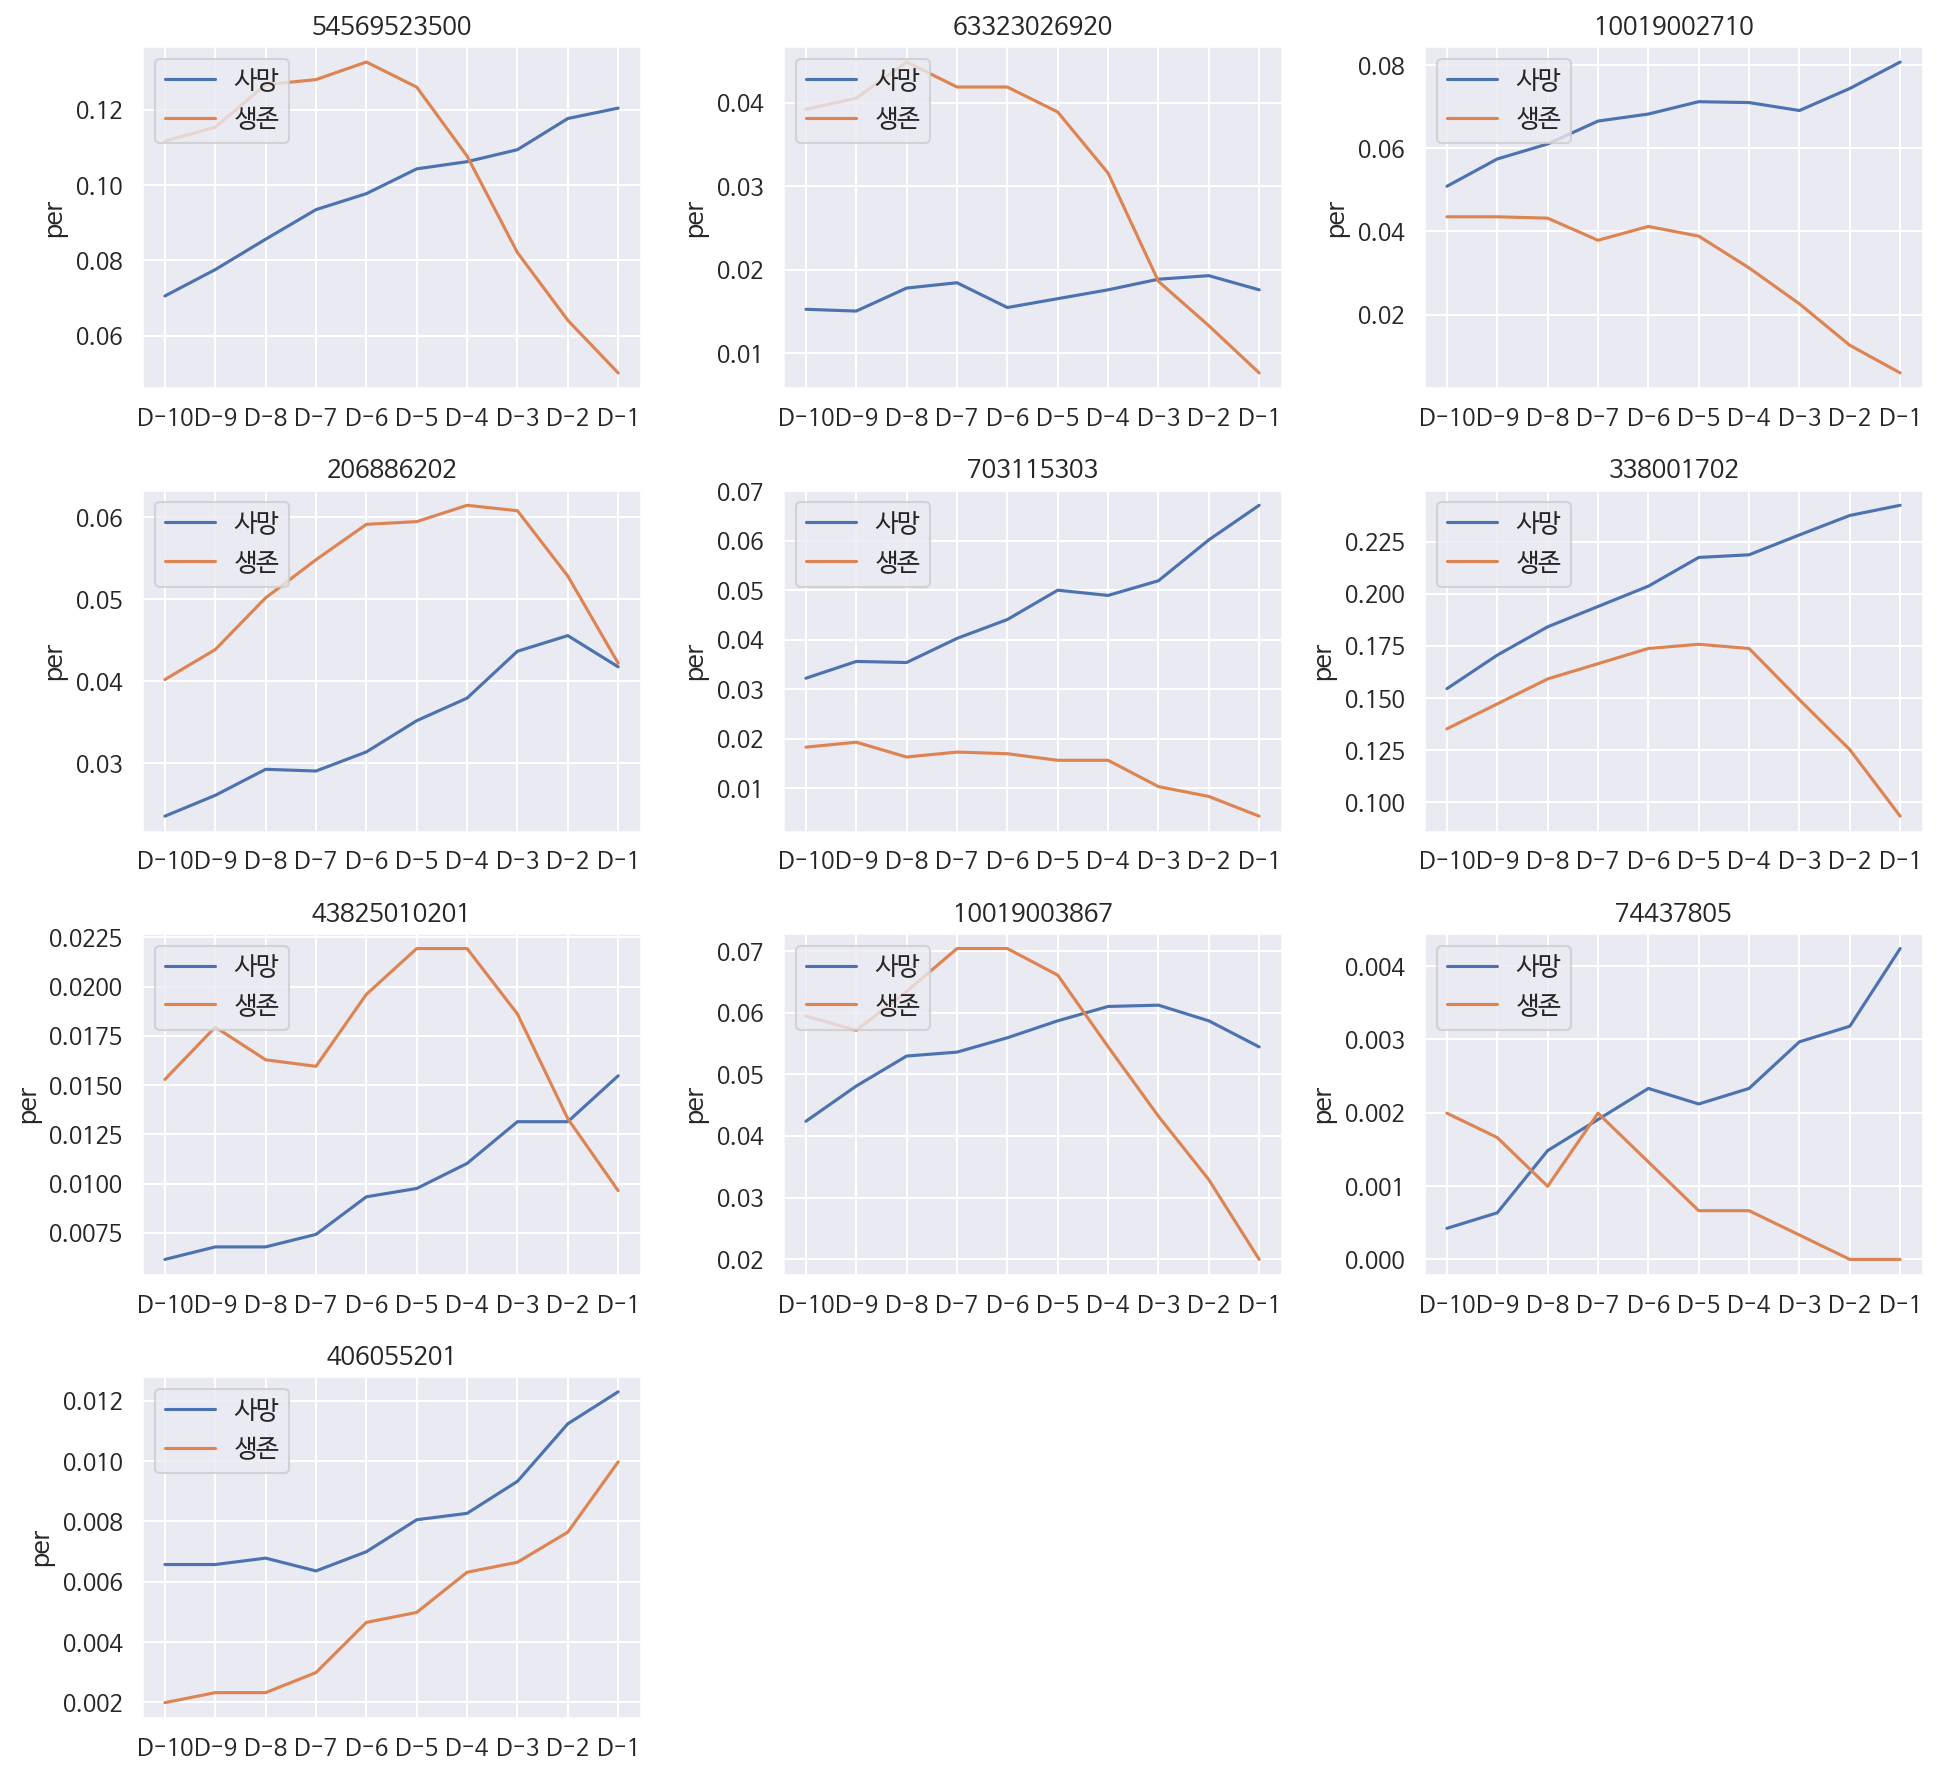

In [9]:
absum(PRE_list,PRE_list[:10])

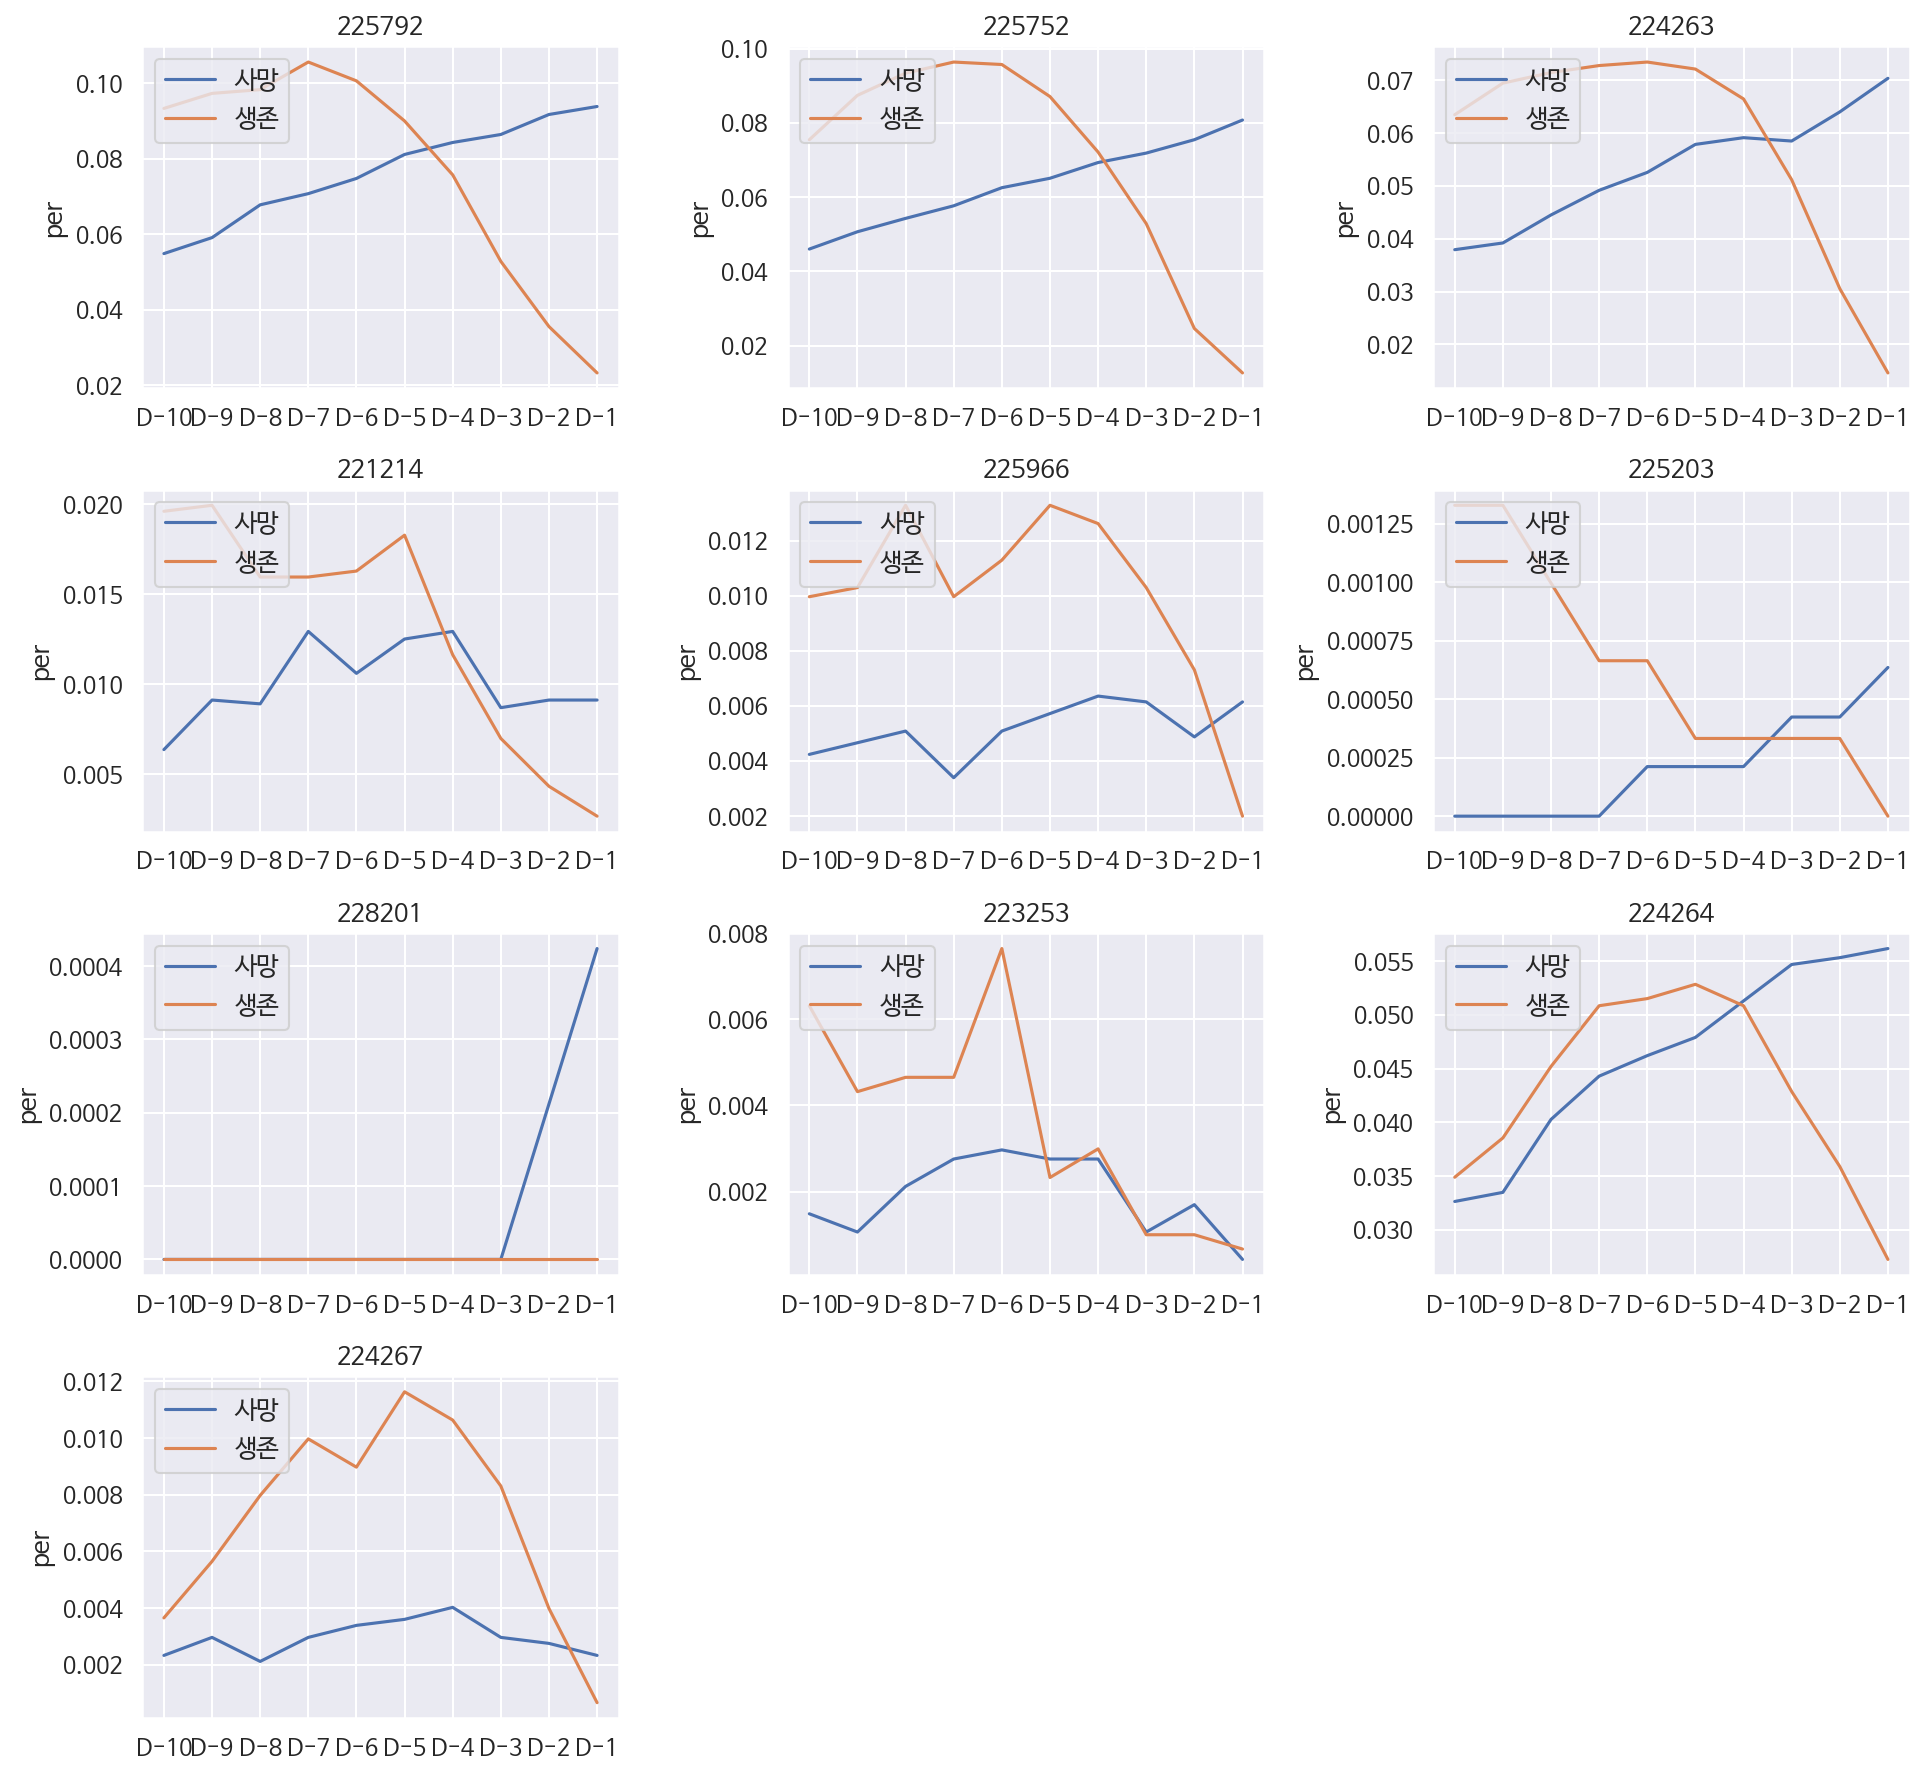

In [10]:
absum(PRO_list,PRO_list[:10])

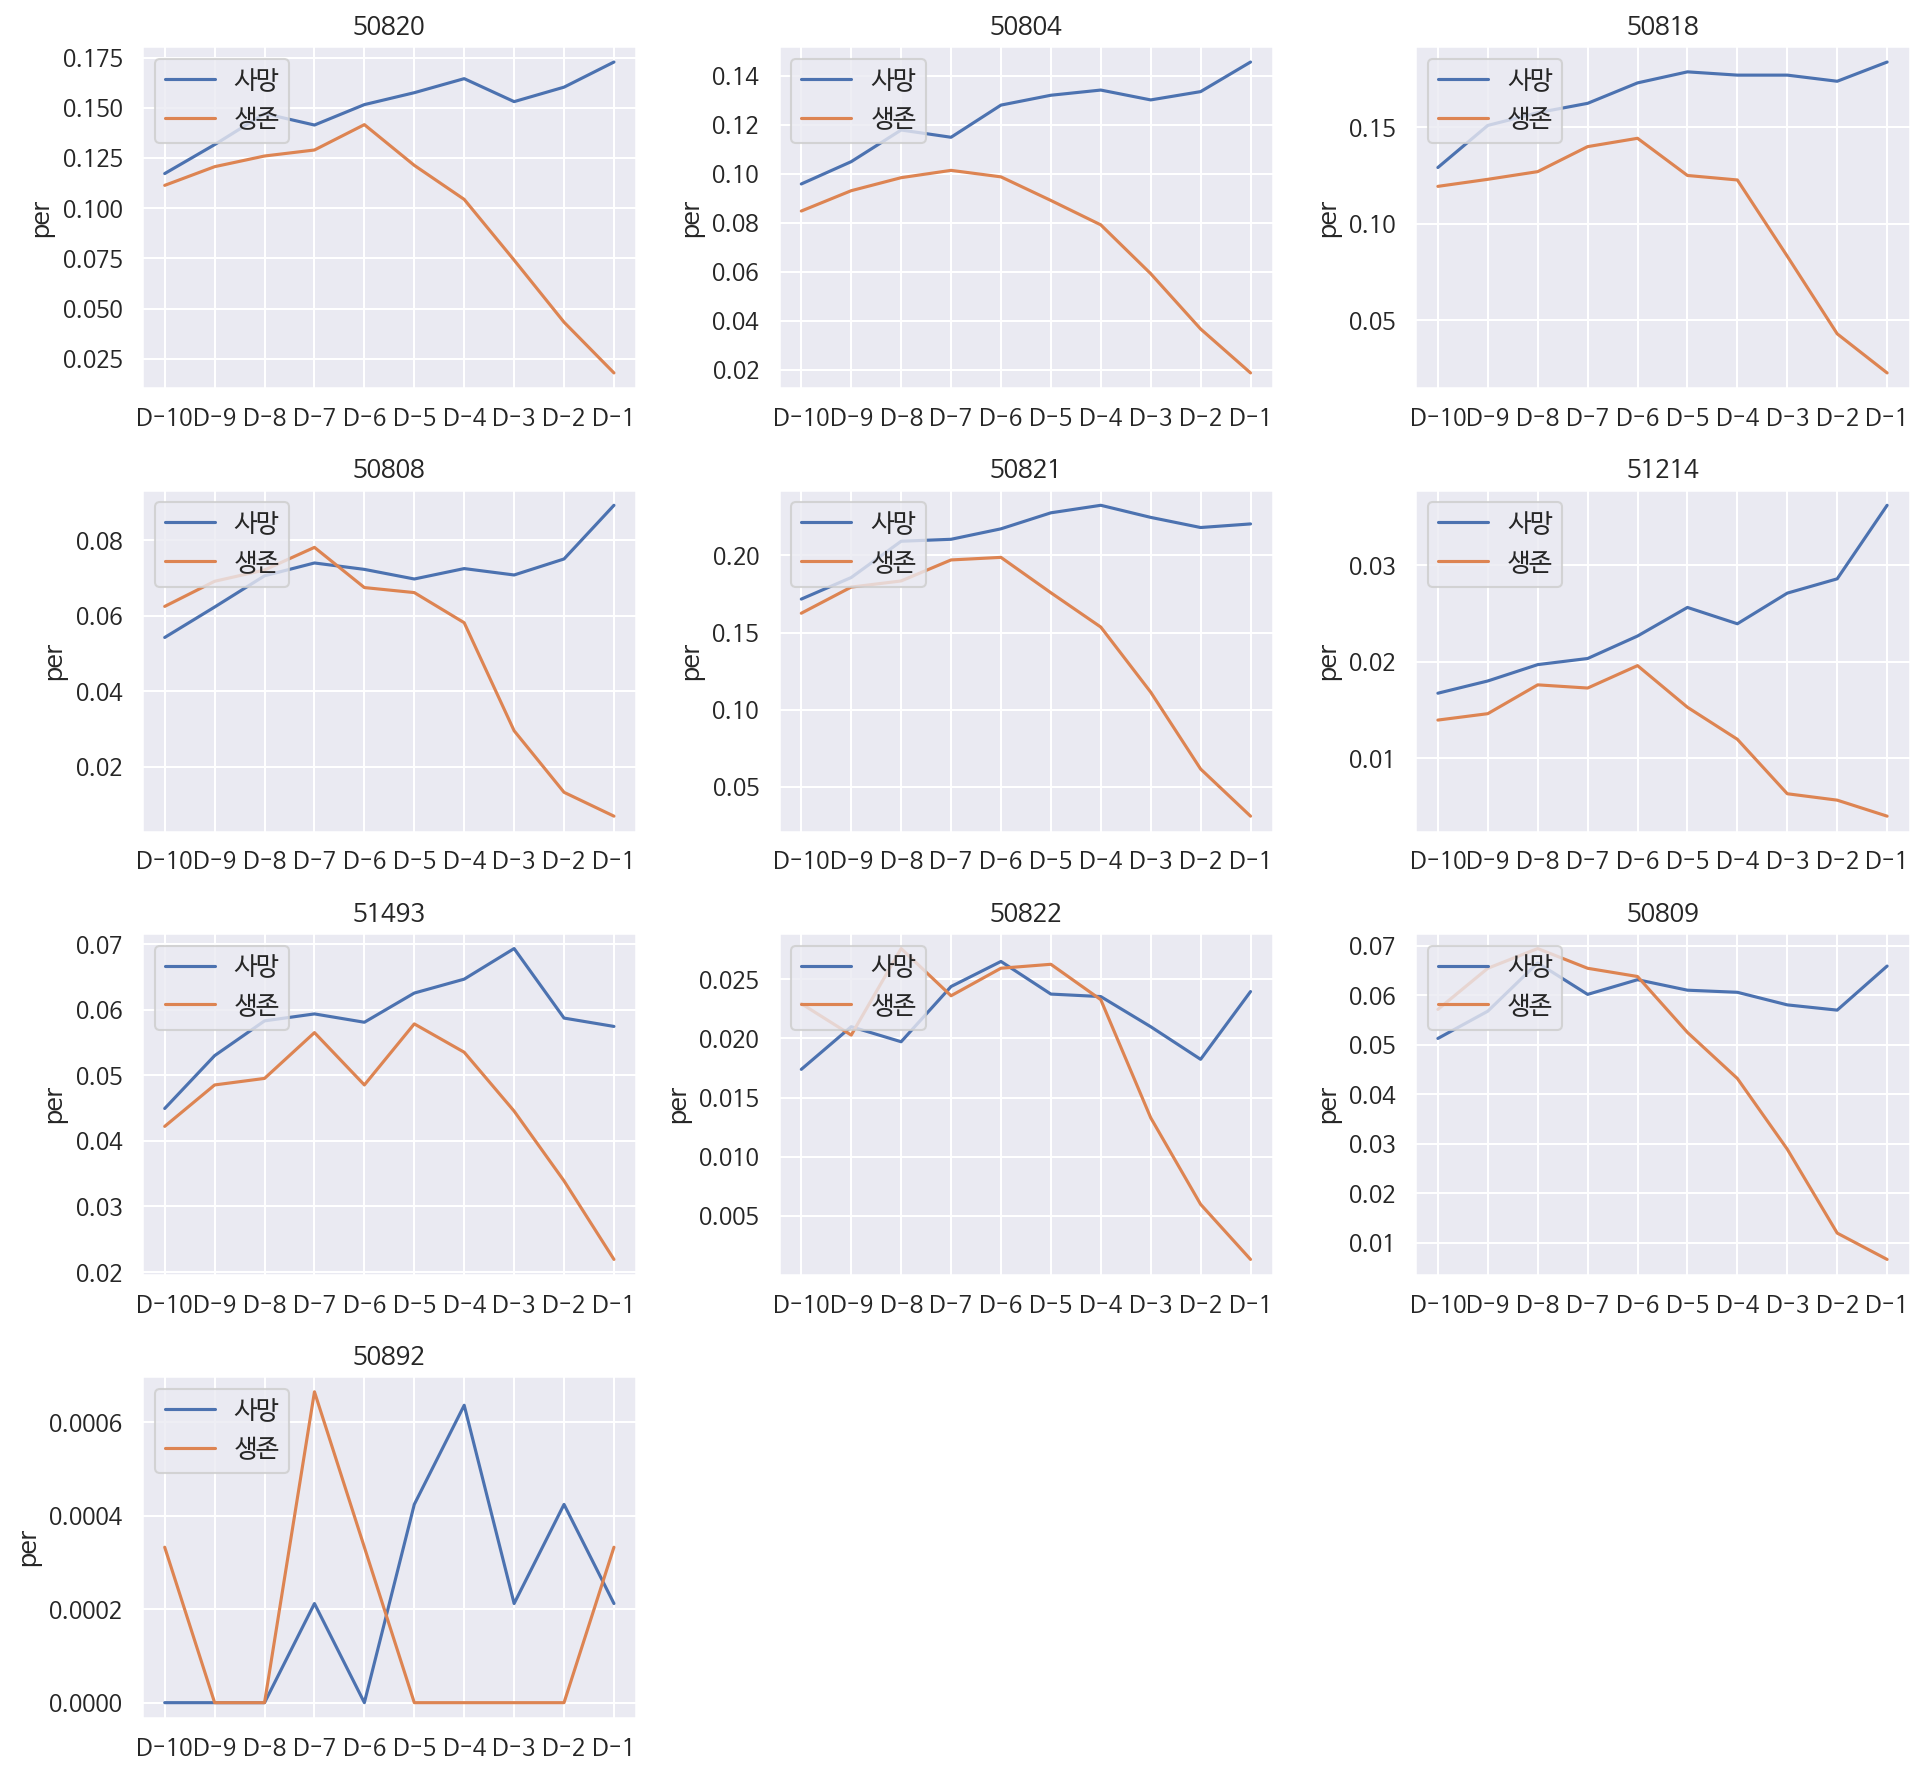

In [11]:
absum(LAB_list,LAB_list[:10])

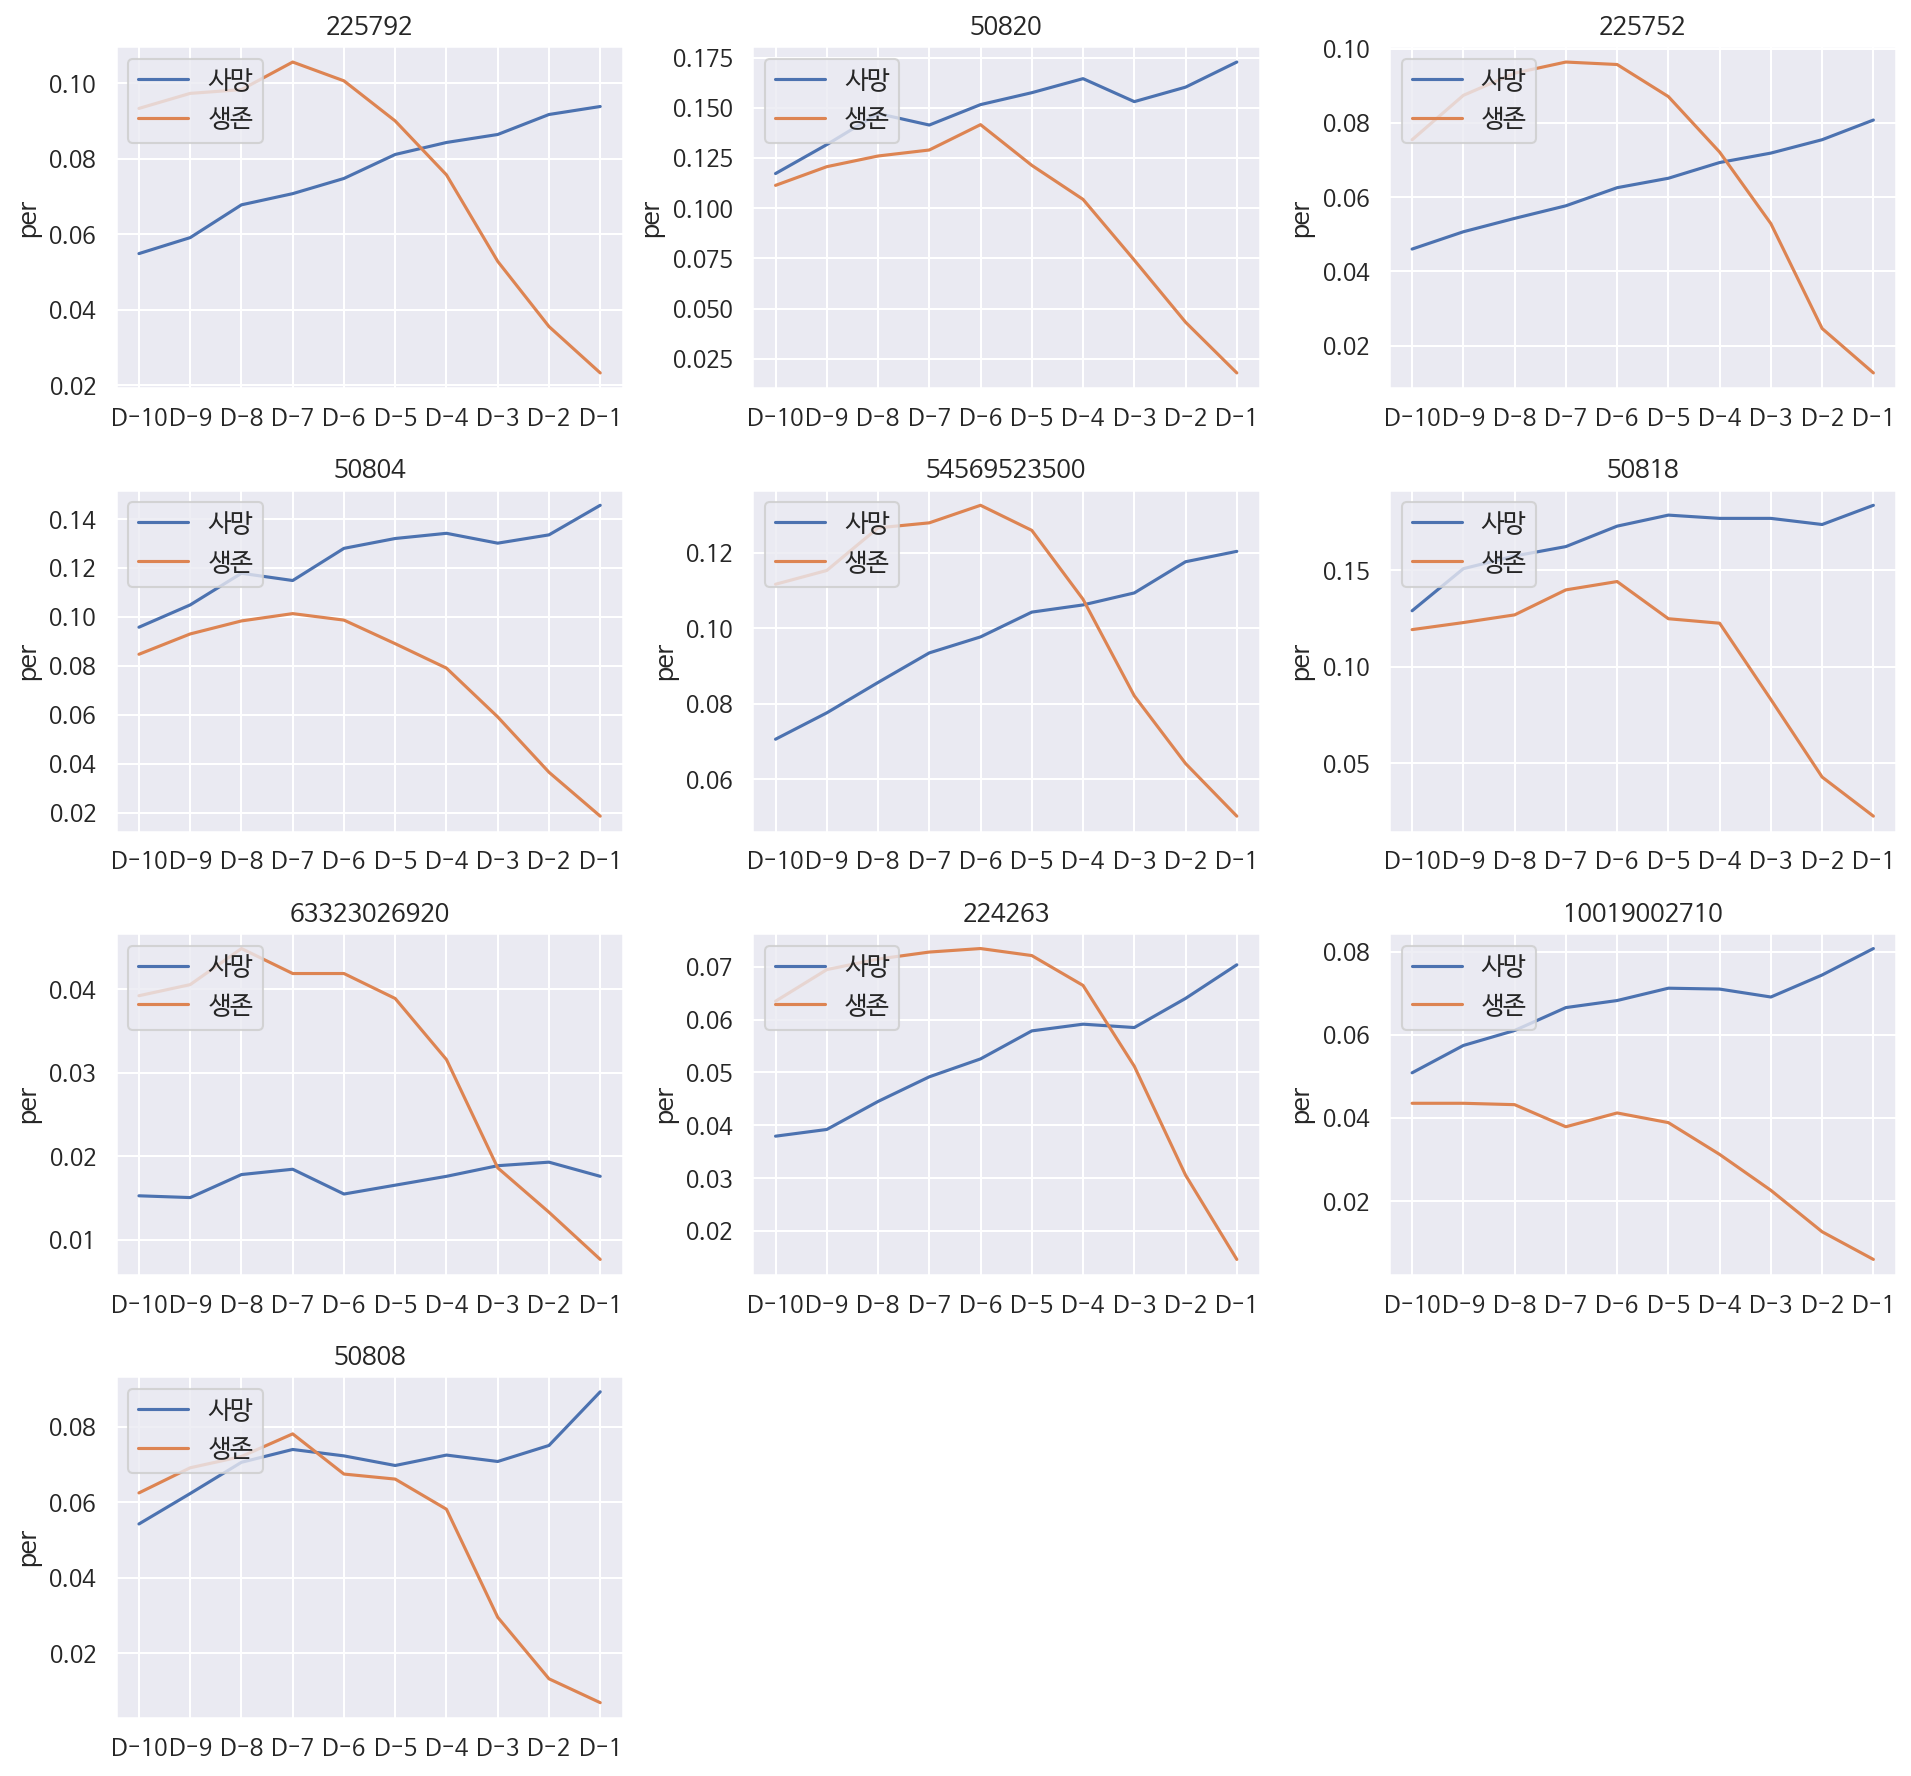

In [12]:
absum(m2_변동성_feature,m2_변동성_feature[:10])